In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from models.ML import terrain_MLP as tmlp

import utils as u
from models import pentzer2014pow
from visualization import multiline, papermode

# papermode(plt, size=12)

In [2]:
ugv_name = "husky"
saved_path = Path("data") / "saved_models"
model_name = tmlp.TerrainMLPClassifier.model_name().lower()
figdir = u.get_figdir("summary", subdir=model_name)
model_name = tmlp.TerrainMLPClassifier.filename()
ugv_mdl_path = saved_path / model_name / ugv_name

In [3]:
# terrain_abbrs = u.import_terrain_abbrs_yaml(("Till", "Vegetal", "Asphalt", "Snow"))
terrain_abbrs = u.import_terrain_abbrs_yaml(("Sandy loam", "Asphalt", "Snow", "Flooring", "Ice"))
terrain_abbrs = {terr:[abbr for abbr in terr_abbrs if u.get_ugv(abbr) == "husky"] for terr, terr_abbrs in terrain_abbrs.items()}
# terrain_abbrs = u.import_terrain_abbrs_yaml()
abbrs = sorted([item for sublist in terrain_abbrs.values() for item in sublist])
# abbrs = [abbr for abbr in abbrs if u.get_ugv(abbr) == "husky"]

In [4]:
dfs = {}
for abbr in abbrs:
    pentz_df = pentzer2014pow.open_model_df(abbr)
    dfs[abbr] = pentz_df
    dfs[abbr]["mass"] = pentz_df.meta.ugv_mass
    dfs[abbr]["terrain"] = u.get_terrain(abbr).lower()

In [5]:
# veloc = ("vx", "vy", "vz")
veloc = ("vx", )
accel_cor = ("ax_corr", "ay_corr", "az_corr")
posit = ("px", "py", "pz")
volts = ("V_L", "V_R")
wheel = ("vL", "vR")
morales = ("JS_sym", "JG")
amps = ("I_L", "I_R")

cols_x = [
    *veloc,
    *accel_cor,
    *volts,
    *wheel,
    *morales,
    *amps,
]

cols_y = ["terrain"]

In [6]:
terrain_dfs = {}
for terr, terr_abbrs in terrain_abbrs.items():
    terr_dfs = [dfs[abbr] for abbr in terr_abbrs]
    terrain_dfs[terr] = pd.concat(terr_dfs, ignore_index=True)
    terrain_dfs[terr]["terrain"] = terr

terr_df = pd.concat(terrain_dfs.values(), ignore_index=True)
terr_df = terr_df[cols_x + cols_y].copy().dropna()

In [7]:
X = terr_df[cols_x].copy()
y = terr_df[cols_y].copy()
terrain_summary = y.terrain.value_counts()
terrains = sorted(terrain_dfs.keys())
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
terrain_summary

ice           14849
flooring      13924
snow           9378
sandy loam     4347
asphalt        3695
Name: terrain, dtype: int64

# Model

In [9]:
mlp_clf = tmlp.TerrainMLPClassifier(max_iter=300)
mlp_clf.fit(X_train, y_train.terrain.values)

TerrainMLPClassifier()

In [10]:
y_pred = mlp_clf.predict(X_test)
mlp_clf.score(X_test, y_test)

0.8573036626547753

# Metrics

In [11]:
y_true = y_test
y_pred = mlp_clf.predict(X_test)
metrics = mlp_clf.metrics(y_true, y_pred)
print(metrics)

Exporting metrics to /home/damien/code/norlab/terrain-power/terrain-code/metrics_ML.json
accuracy                                              0.857304
precision    [0.7825030376670717, 0.8568778160614895, 0.918...
recall       [0.6887700534759358, 0.9300920598388953, 0.887...
f1-score     [0.7326507394766781, 0.8919851013932957, 0.902...
dtype: object


['vx', 'ax_corr', 'ay_corr', 'az_corr', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


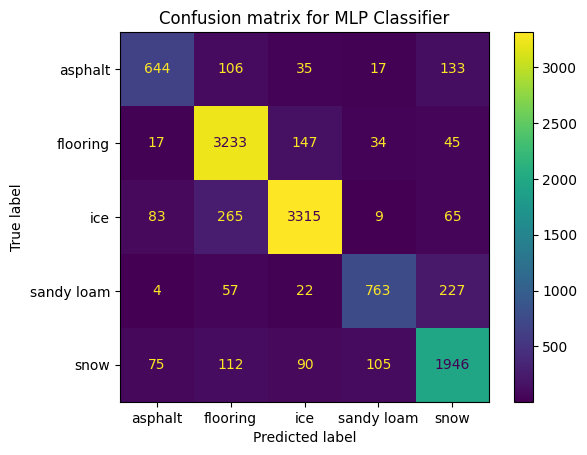

In [12]:
disp = mlp_clf.confusion_matrix(y_test, y_pred)
print(cols_x)

['vx', 'ax_corr', 'ay_corr', 'az_corr', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


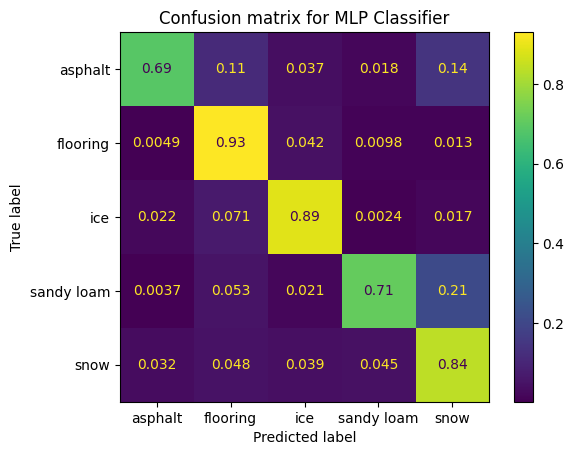

In [13]:
disp = mlp_clf.confusion_matrix(y_test.terrain, y_pred, normalization="true", figdir=figdir)
print(cols_x)

In [14]:
mlp_clf.export_model(ugv_mdl_path)

Exporting models in /home/damien/code/norlab/terrain-power/terrain-code/data/saved_models/mlp-classifier/husky


In [15]:
pred_proba = mlp_clf.predict_proba(X_test)
pred_proba

array([[1.34276006e-02, 5.24815102e-01, 2.66384179e-01, 4.94341684e-02,
        1.45938950e-01],
       [5.84794677e-04, 9.54639135e-01, 3.34162455e-04, 2.87953968e-02,
        1.56465107e-02],
       [4.83236640e-02, 1.14490713e-03, 1.63720120e-05, 9.36225766e-01,
        1.42892912e-02],
       ...,
       [1.00825249e-02, 2.52535239e-03, 9.99820624e-04, 5.88481993e-01,
        3.97910309e-01],
       [3.02915095e-02, 9.51127090e-01, 9.77573347e-04, 1.62853554e-03,
        1.59752912e-02],
       [1.14315166e-04, 4.91106816e-05, 9.91305774e-01, 1.76402725e-05,
        8.51315988e-03]])

In [16]:
print(X_test.iloc[1])
print(mlp_clf.predict([X_test.iloc[0]]).item())
print(y_test.iloc[0])

vx         -0.063106
ax_corr     0.167428
ay_corr     0.051362
az_corr    -0.036828
V_L        24.180000
V_R        24.220000
vL          0.039370
vR         -0.110236
JS_sym     51.783558
JG          0.149606
I_L         9.920000
I_R         8.730000
Name: 30662, dtype: float64
flooring
terrain    flooring
Name: 18854, dtype: object


/home/damien/code/norlab/terrain-power/terrain-code/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but TerrainMLPClassifier was fitted with feature names
  warnings.warn(


In [17]:
# fig, ax = plt.subplots(figsize=(8,6))

# ax.bar(X_test.columns.values, mlp_clf.feature_importances_)
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_xlabel("Feature")
# ax.set_ylabel("Feature\nimportance")
# ax.set_title("Feature importance for Random Forest Classifier")
# fig.tight_layout()

In [18]:
if False:
    mlp_clf.cross_val_metrics(X, y)

# Unseen data

In [19]:
unseen = pentzer2014pow.open_model_df("H74")
unseen["mass"] = unseen.meta.ugv_mass
unseen = unseen[cols_x + ["P_motion", "time_rel"]].copy().dropna()
unseen = unseen.dropna()

In [20]:
print(unseen.shape)
unseen.head()

(6290, 14)


vx   ax_corr   ay_corr   az_corr    V_L    V_R        vL  \
0 -2.254265e-16 -0.978097 -0.007367  0.049040  23.16  23.16  0.055118   
1  3.561989e-03 -1.104764 -0.102631  0.047878  23.06  22.99  0.173228   
2  2.780546e-02 -0.546486 -0.090610 -0.066458  22.92  22.92  0.220472   
3  3.611061e-02  0.482854  0.093764  0.075668  23.16  23.16  0.220472   
4  4.441576e-02 -0.053227 -0.068949 -0.015779  23.13  23.09  0.220472   

         vR    JS_sym        JG   I_L   I_R   P_motion  time_rel  
0  0.055118  3.332478  0.110236  0.00  5.19   5.334564  0.000000  
1  0.173228  1.733511  0.346457  1.64  6.76  27.135356  0.160083  
2  0.236220  1.085047  0.456693  1.91  6.37  35.913232  0.271713  
3  0.244094  3.731143  0.464567  0.00  3.88  17.661475  0.383233  
4  0.244094  2.310931  0.464567  0.00  4.01  18.253226  0.527148

In [21]:
X_unseen = unseen[cols_x].copy()
pred_unseen = mlp_clf.predict_idx(X_unseen)
pred_unseen


array([2, 1, 4, ..., 4, 4, 4])

In [22]:
y_unseen = mlp_clf.predict(X_unseen)

Text(0.5, 0, 'Elapsed time (s)')

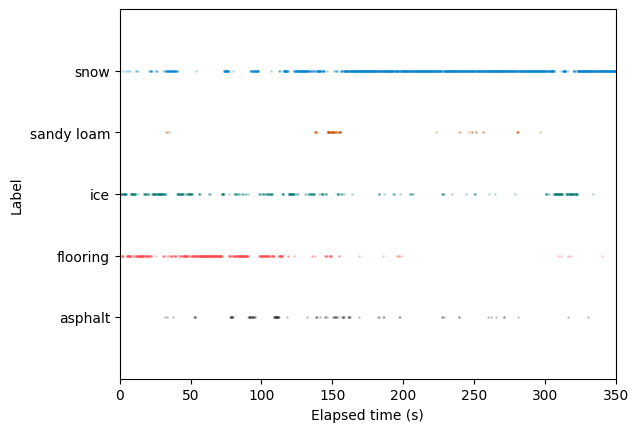

In [24]:
fig, ax = plt.subplots()

for idx, terr in enumerate(mlp_clf.classes_):
    terr_idx = y_unseen == terr
    terr_time = unseen.time_rel.loc[terr_idx]
    terr_label = idx * np.ones(terr_time.shape)
    ax.plot(
        terr_time,
        terr_label,
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.2,
    )

ax.set_yticks(np.arange(mlp_clf.len_classes()), mlp_clf.classes_)

ax.set_ylim(bottom=-1, top=mlp_clf.len_classes())
ax.set_xlim(left=0, right=350)
ax.set_ylabel("Label")
ax.set_xlabel("Elapsed time (s)")